In [41]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [42]:
FILE_NAME="Console_Acq_0000.mat"

In [43]:
mat_contents = scipy.io.loadmat(f'doric/{FILE_NAME}')

Events shape: (1, 8)
Event structure: ('RawTrace', 'RawTime', 'RawTrace_z', 'Channel', 'WaveformTime', 'Waveforms', 'EventTimes', 'Clusters', 'ClusterSize', 'PCs', 'StimOn', 'StimOff')
Raw trace shape: (10937824,)
Raw time shape: (10937824,)
Time range: 0.000000 to 364.776397
Voltage range: -0.162519 to 0.080281


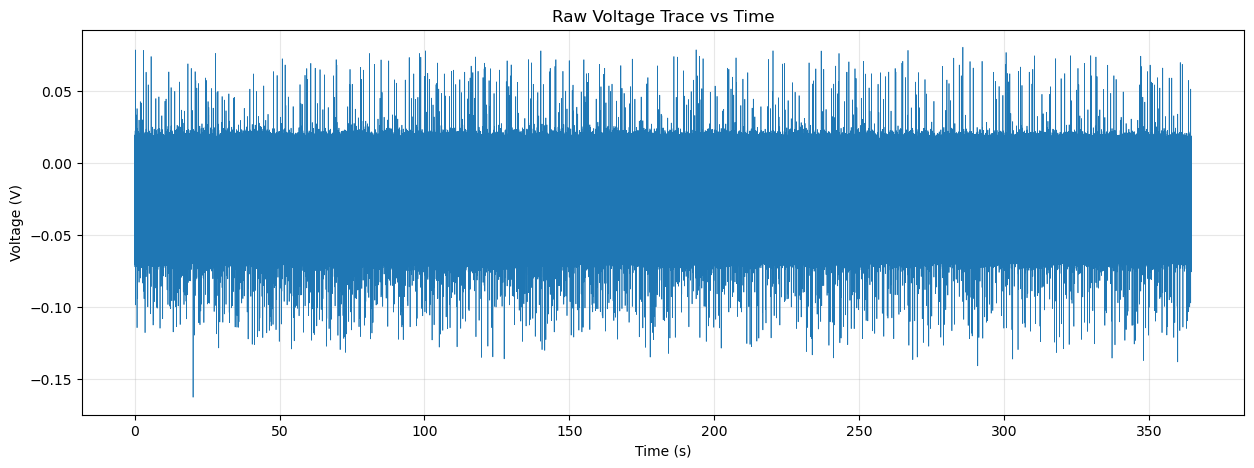

In [44]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Load the data
mat_contents = scipy.io.loadmat('doric/Console_Acq_0012.mat')
events = mat_contents['Events']

print("Events shape:", events.shape)

# The third event (index 2) contains the actual data
event = events[0, 2]  # Access the third event which has data

print("Event structure:", event.dtype.names)

# Extract the voltage trace and time data
raw_trace = event[0].flatten()  # First element is RawTrace
raw_time = event[1].flatten()   # Second element is RawTime

print(f"Raw trace shape: {raw_trace.shape}")
print(f"Raw time shape: {raw_time.shape}")
print(f"Time range: {raw_time.min():.6f} to {raw_time.max():.6f}")
print(f"Voltage range: {raw_trace.min():.6f} to {raw_trace.max():.6f}")

# Plot the voltage trace
plt.figure(figsize=(15, 5))
plt.plot(raw_time, raw_trace, linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Raw Voltage Trace vs Time')
plt.grid(True, alpha=0.3)
plt.show()

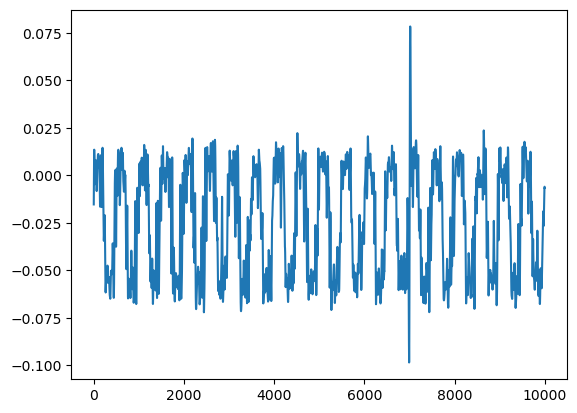

In [45]:
plt.plot(raw_trace[:10000])
plt.show()

In [46]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(raw_trace, height=0.06)

print(f"Found {len(peaks)} peaks")
print(f"Peak indices: {peaks[:10]}")

Found 143 peaks
Peak indices: [   7017   91502  117484  169484  352965  550380  584938  624985  836249
 1229563]


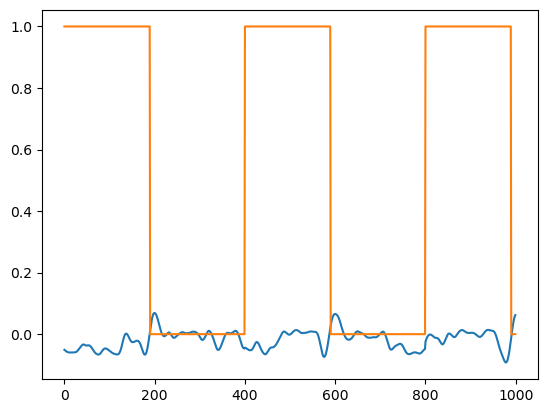

In [52]:
voltage_data = []
time_data = []

PAD = 200
START = 250
END = 10

for i in peaks:
    voltage_data.extend(raw_trace[i-PAD:i+PAD])
    time_data.extend(raw_time[i-PAD:i+PAD])

#----
# time_step = raw_time[1] - raw_time[0]
# time_data = np.arange(0, len(voltage_data) * time_step, time_step)
#----
labels = []

for i in peaks:
    start_idx = max(0, i - PAD)
    end_idx = min(len(raw_trace), i + PAD)
    
    segment_labels = [0] * (end_idx - start_idx)
    
    label_start = max(0, i - START - start_idx)
    label_end = min(len(segment_labels), i - END - start_idx)
    
    if label_end > label_start:
        segment_labels[label_start:label_end] = [1] * (label_end - label_start)
    
    labels.extend(segment_labels)

#----
plt.plot(voltage_data[2000:3000])
plt.plot(labels[2000:3000])
plt.show()

In [53]:
from scipy.signal import stft

def sliding_stft_with_labels(voltage_data, labels, raw_time, window_size=40, step=10):
    features = []
    times = []
    window_labels = []
    
    for i in range(0, len(voltage_data) - window_size, step):
        # Extract window
        window = voltage_data[i:i+window_size]
        time = time_data[i:i+window_size]
        # Get STFT
        f, t, Zxx = stft(window, nperseg=50, noverlap=25)
        features.append(np.abs(Zxx).flatten())
        times.append(time)
        # Get majority label for this window
        window_label = 1 if np.mean(labels[i:i+window_size]) > 0.5 else 0
        window_labels.append(window_label)
    
    return np.array(features), np.array(window_labels), np.array(times)

features, window_labels, times = sliding_stft_with_labels(voltage_data, labels, raw_time, window_size=100, step=10)

print(f"Features shape: {features.shape}")
print(f"Labels shape: {window_labels.shape}")
print(f"Times shape: {times.shape}")

Features shape: (5710, 130)
Labels shape: (5710,)
Times shape: (5710, 100)


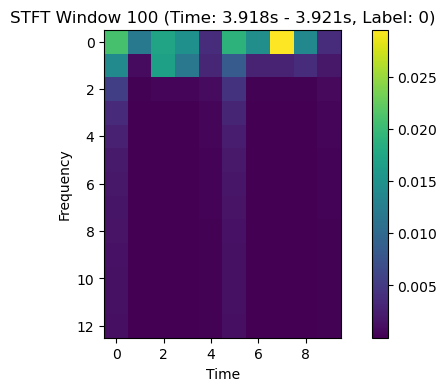

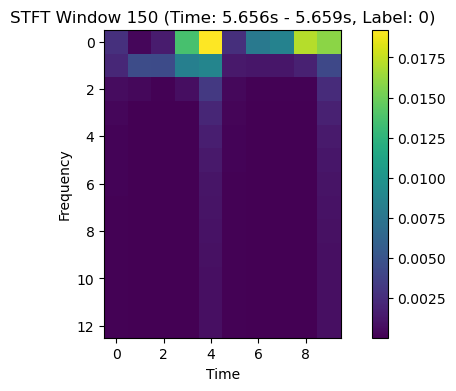

In [54]:
for i in range(100, 200, 50):
    plt.figure(figsize=(8, 4))
    plt.imshow(features[i].reshape(13, 10))  # Reshape to 2D for imshow
    plt.colorbar()
    
    # Get the time range and label for this feature
    time_window = times[i]
    start_time = time_window[0]
    end_time = time_window[-1]
    label = window_labels[i]
    
    plt.title(f'STFT Window {i} (Time: {start_time:.3f}s - {end_time:.3f}s, Label: {label})')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

In [55]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=130, num_classes=2, d_model=32, nhead=4, num_layers=2):
        super().__init__()
        
        # Fixed reshape for 130 features -> 10 timesteps x 13 features
        self.seq_len = 10
        self.feature_dim = 13
        
        self.input_projection = nn.Linear(self.feature_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=128,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, num_classes)
        )
    
    def forward(self, x):
        # x shape: (batch, 130)
        x = x.view(-1, self.seq_len, self.feature_dim)  # (batch, 10, 13)
        x = self.input_projection(x)  # (batch, 10, d_model)
        x = self.positional_encoding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.classifier(x)

Class 0: 3140 (55.0%)
Class 1: 2570 (45.0%)
Epoch 1: Loss=0.5442, Acc=86.43%, F1=0.8635, LR=0.000500
Epoch 2: Loss=0.3647, Acc=88.70%, F1=0.8864, LR=0.000500
Epoch 3: Loss=0.3011, Acc=87.04%, F1=0.8669, LR=0.000500
Epoch 4: Loss=0.2636, Acc=92.03%, F1=0.9201, LR=0.000500
Epoch 5: Loss=0.2228, Acc=91.77%, F1=0.9174, LR=0.000500
Epoch 6: Loss=0.2027, Acc=92.56%, F1=0.9256, LR=0.000500
Epoch 7: Loss=0.2006, Acc=93.61%, F1=0.9357, LR=0.000500
Epoch 8: Loss=0.1710, Acc=92.29%, F1=0.9231, LR=0.000500
Epoch 9: Loss=0.1684, Acc=94.66%, F1=0.9465, LR=0.000500
Epoch 10: Loss=0.1637, Acc=94.22%, F1=0.9420, LR=0.000500
Epoch 11: Loss=0.1475, Acc=95.10%, F1=0.9508, LR=0.000500
Epoch 12: Loss=0.1439, Acc=94.22%, F1=0.9422, LR=0.000500
Epoch 13: Loss=0.1451, Acc=94.75%, F1=0.9473, LR=0.000500
Epoch 14: Loss=0.1337, Acc=94.92%, F1=0.9492, LR=0.000500
Epoch 15: Loss=0.1310, Acc=95.71%, F1=0.9570, LR=0.000500
Epoch 16: Loss=0.1245, Acc=95.36%, F1=0.9535, LR=0.000500
Epoch 17: Loss=0.1193, Acc=95.97%, F1

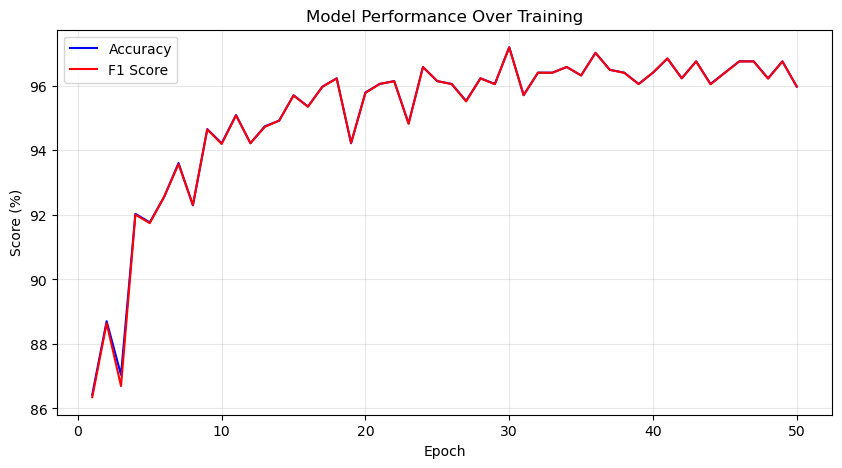

In [56]:
# Load your data (assuming features and window_labels are defined)
X = features
y = window_labels

# Check class balance
print(f"Class 0: {np.sum(y==0)} ({100*np.mean(y==0):.1f}%)")
print(f"Class 1: {np.sum(y==1)} ({100*np.mean(y==1):.1f}%)")

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create datasets and loaders
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
model = TimeSeriesTransformer()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

accuracies = []
f1_scores = []

# Training loop
for epoch in range(50):
    # Train
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    
    # Evaluate
    model.eval()
    correct = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            
            # Collect predictions for F1 score
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * correct / len(test_dataset)
    avg_loss = train_loss / len(train_loader)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Store metrics
    accuracies.append(accuracy)
    f1_scores.append(f1)
    
    scheduler.step(avg_loss)
    
    print(f'Epoch {epoch+1}: Loss={avg_loss:.4f}, Acc={accuracy:.2f}%, F1={f1:.4f}, LR={optimizer.param_groups[0]["lr"]:.6f}')

# Plot results
plt.figure(figsize=(10, 5))
epochs = range(1, len(accuracies) + 1)

plt.plot(epochs, accuracies, 'b-', label='Accuracy')
plt.plot(epochs, [f1*100 for f1 in f1_scores], 'r-', label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score (%)')
plt.title('Model Performance Over Training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

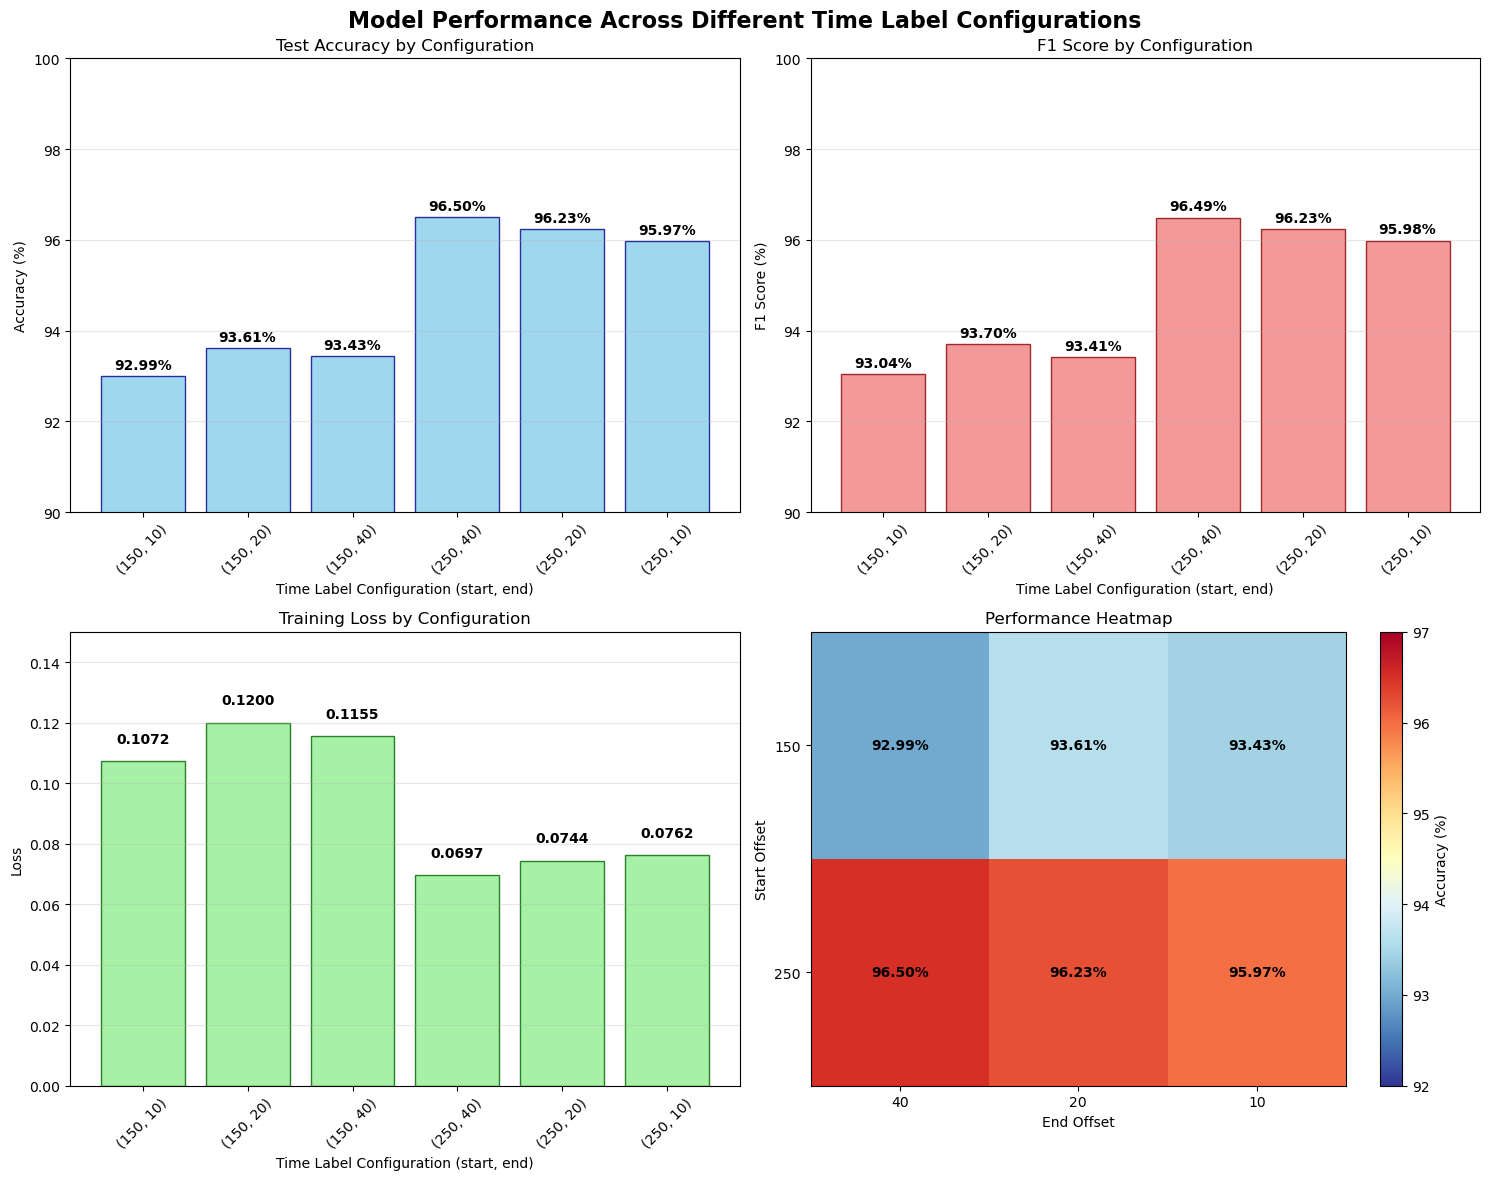

=== PERFORMANCE SUMMARY ===
Best Accuracy: 96.50% (Config: (250, 40))
Best F1 Score: 0.9649 (Config: (250, 40))
Lowest Loss: 0.0697 (Config: (250, 40))

=== CONFIGURATION ANALYSIS ===
150 start offset:
  End 10: Acc=92.99%, F1=0.9304
  End 20: Acc=93.61%, F1=0.9370
  End 40: Acc=93.43%, F1=0.9341

250 start offset:
  End 40: Acc=96.50%, F1=0.9649
  End 20: Acc=96.23%, F1=0.9623
  End 10: Acc=95.97%, F1=0.9598


In [58]:
import matplotlib.pyplot as plt
import numpy as np

configs = [
    (150, 10), (150, 20), (150, 40),
    (250, 40), (250, 20), (250, 10)
]

accuracies = [92.99, 93.61, 93.43, 96.50, 96.23, 95.97]
f1_scores = [0.9304, 0.9370, 0.9341, 0.9649, 0.9623, 0.9598]
losses = [0.1072, 0.1200, 0.1155, 0.0697, 0.0744, 0.0762]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Across Different Time Label Configurations', fontsize=16, fontweight='bold')

x_pos = np.arange(len(configs))
bars1 = ax1.bar(x_pos, accuracies, color='skyblue', alpha=0.8, edgecolor='navy', linewidth=1)
ax1.set_xlabel('Time Label Configuration (start, end)')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Test Accuracy by Configuration')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'({start}, {end})' for start, end in configs], rotation=45)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(90, 100)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

bars2 = ax2.bar(x_pos, [f1*100 for f1 in f1_scores], color='lightcoral', alpha=0.8, edgecolor='darkred', linewidth=1)
ax2.set_xlabel('Time Label Configuration (start, end)')
ax2.set_ylabel('F1 Score (%)')
ax2.set_title('F1 Score by Configuration')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'({start}, {end})' for start, end in configs], rotation=45)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(90, 100)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

bars3 = ax3.bar(x_pos, losses, color='lightgreen', alpha=0.8, edgecolor='darkgreen', linewidth=1)
ax3.set_xlabel('Time Label Configuration (start, end)')
ax3.set_ylabel('Loss')
ax3.set_title('Training Loss by Configuration')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'({start}, {end})' for start, end in configs], rotation=45)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim(0, 0.15)

for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

performance_matrix = np.array([
    [accuracies[0], accuracies[1], accuracies[2]],
    [accuracies[3], accuracies[4], accuracies[5]]
])

im = ax4.imshow(performance_matrix, cmap='RdYlBu_r', aspect='auto', vmin=92, vmax=97)
ax4.set_xlabel('End Offset')
ax4.set_ylabel('Start Offset')
ax4.set_title('Performance Heatmap')
ax4.set_xticks([0, 1, 2])
ax4.set_xticklabels(['40', '20', '10'])
ax4.set_yticks([0, 1])
ax4.set_yticklabels(['150', '250'])

for i in range(2):
    for j in range(3):
        text = ax4.text(j, i, f'{performance_matrix[i, j]:.2f}%',
                        ha="center", va="center", color="black", fontweight='bold')

cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Accuracy (%)')

plt.tight_layout()
plt.show()

print("=== PERFORMANCE SUMMARY ===")
print(f"Best Accuracy: {max(accuracies):.2f}% (Config: {configs[accuracies.index(max(accuracies))]})")
print(f"Best F1 Score: {max(f1_scores):.4f} (Config: {configs[f1_scores.index(max(f1_scores))]})")
print(f"Lowest Loss: {min(losses):.4f} (Config: {configs[losses.index(min(losses))]})")

print("\n=== CONFIGURATION ANALYSIS ===")
print("150 start offset:")
for i in range(3):
    print(f"  End {configs[i][1]}: Acc={accuracies[i]:.2f}%, F1={f1_scores[i]:.4f}")

print("\n250 start offset:")
for i in range(3, 6):
    print(f"  End {configs[i][1]}: Acc={accuracies[i]:.2f}%, F1={f1_scores[i]:.4f}")